In [3]:
import numpy as np, pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import ceam_tests.util as ctu

from ceam.framework.event import listens_for
# from ceam.framework.values import produces_value, modifies_value
from ceam.framework.population import uses_columns

np.random.seed(12345)  # set random seed for reproducibility

n_simulants = 50
n_days = 5000
t_timestep = 1 # days
t_start = pd.Timestamp('1990-01-01')

# Firefly micromechanism

Each agent is a firefly.  It has a clock, and at time 0 it lights up.  It also has neighbors, and if it sees a neighbor light up before it does, it jumps its clock forward one.  This should lead all fireflies to sync up.

In [4]:
def is_glowing(df):
    return (df.age % 10) < 1
is_glowing(pd.DataFrame({'age':np.random.uniform(low=0, high=100, size=25)})).value_counts()

False    21
True      4
Name: age, dtype: int64

In [5]:
@listens_for('initialize_simulants', priority=0)
@uses_columns(['age', 'sex', 'glow'])
def my_generate_base_population(event):
    """ Base population needs nothing, really
    
    updates columns age and sex because CEAM expects them
    """
    population = pd.DataFrame(index=event.index)
    population['age'] = np.random.uniform(low=0, high=10, size=len(population))
    population['sex'] = '-'
    population['glow'] = is_glowing(population)

    # update the population in the model
    event.population_view.update(population)

# instead of using simulate, just do this:
components = [my_generate_base_population]
simulation = ctu.setup_simulation(components, population_size=n_simulants, start=t_start)
ctu.pump_simulation(simulation, time_step_days=t_timestep, duration=pd.Timedelta(days=n_days))

# take a look at the population at the end of the sim
simulation.population.population.glow.mean()

0.080000000000000002

In [6]:
glow_mean = []
glow=

@listens_for('time_step')
@uses_columns(['age', 'glow'])
def advance_clock_independently(event):
    t = event.population
    t.age += np.random.uniform(low=0, high=.1, size=len(t))
    t.glow = is_glowing(t)
    event.population_view.update(t)
    glow_mean.append(t.glow.mean())

components = [my_generate_base_population, advance_clock_independently]
simulation = ctu.setup_simulation(components, population_size=n_simulants, start=t_start)
%time ctu.pump_simulation(simulation, time_step_days=t_timestep, duration=pd.Timedelta(days=n_days))


# take a look at the population at the end of the sim
simulation.population.population.glow.mean()

CPU times: user 17.8 s, sys: 24 ms, total: 17.9 s
Wall time: 17.9 s


0.12

(-249.95000000000002, 5248.9499999999998, -0.013000000000000001, 1)

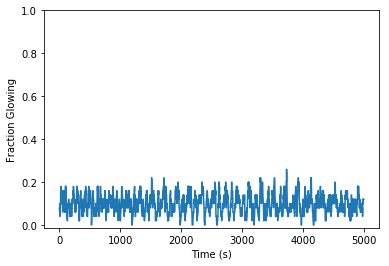

In [7]:
plt.plot(glow_mean)
plt.xlabel('Time (s)')
plt.ylabel('Fraction Glowing')
plt.axis(ymax=1)

In [9]:
def my_rewired_band(n, k, p):
    """ SW Network
    k : int, width of band-1/2
    p : probability of rewiring
    """
    A = np.eye(n)
    for i in range(n):
        for j in range(i-k,i+k+1):
            if np.random.uniform() < p:
                A[i, np.random.randint(n)] = 1
            else:
                A[i, (j%n)] = 1
    return A
            
my_rewired_band(10, k=2, p=.5)

#adjacency_matrix = np.ones((n_simulants, n_simulants)).astype(bool)
adjacency_matrix = my_rewired_band(n_simulants, k=5, p=.2).astype(bool)

In [10]:
glow_mean = []

def neighbors_glowing(glow):
    neighbor_glow = np.dot(adjacency_matrix, glow)
    return neighbor_glow > 0

@listens_for('time_step')
@uses_columns(['age', 'glow'])
def advance_clock_from_neighbors(event):
    t = event.population

    see_glow = neighbors_glowing(t.glow)
    advance_clock = see_glow & (t.age % 10 >= 5)
    t.age[advance_clock] += np.random.uniform(low=0, high=.1, size=sum(advance_clock))
    
    event.population_view.update(t)
    


components = [my_generate_base_population, advance_clock_independently, advance_clock_from_neighbors]
simulation = ctu.setup_simulation(components, population_size=n_simulants, start=t_start)
%time ctu.pump_simulation(simulation, time_step_days=t_timestep, duration=pd.Timedelta(days=n_days))


# take a look at the population at the end of the sim
simulation.population.population.glow.mean()    

/home/james/miniconda3/envs/ceam_development/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


CPU times: user 4min 25s, sys: 248 ms, total: 4min 26s
Wall time: 4min 27s


0.0

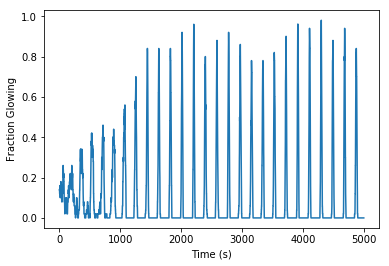

In [11]:
plt.plot(glow_mean)
plt.xlabel('Time (s)')
plt.ylabel('Fraction Glowing')